In [1]:
%matplotlib inline
import cmlreaders as cml
from cmlreaders import CMLReader, get_data_index
import matplotlib.pyplot as plt 
import matplotlib as mp
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D

import scipy 
from scipy import stats 

import pandas as pd 
import numpy as np
import os 
import sys

import pybeh_pd as pb
import pybeh_pd_min as pb_min
import seaborn as sns
import importlib

from brokenaxes import brokenaxes
import seaborn as sns

In [2]:
def loftus_masson(df, sub_cols, cond_col, value_col, within_cols=[]):
    if not isinstance(sub_cols, list):
        sub_cols = [sub_cols]
    if not isinstance(within_cols, list):
        within_cols = [within_cols]
    df = df.copy()
    if len(within_cols) > 0:
        df['M'] = df.groupby(within_cols)[value_col].transform('mean')
    else:
        df['M'] = df[value_col].mean()
    df['M_S'] = df.groupby(sub_cols + within_cols)[value_col].transform('mean')
    df['adj_' + value_col] = (df[value_col] + df['M'] - df['M_S'])
    return df

In [4]:
exp2_data = pd.read_csv('dataframes/exp2_ffr_evs.csv')

/home1/rafla/.conda/envs/cml_environment/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (7,21,24,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Semantic CRP

## Overall effect

In [5]:
sem_sim_num_df = pd.read_csv('dataframes/exp2_sem_sim_num_df.csv')

In [6]:
sem_sims = pd.pivot_table(sem_sim_num_df, index='item_num_1', columns='item_num_2', values='similarity', dropna=False)

In [7]:
ffr_evs = exp2_data.query("type == 'REC_WORD'")
ffr_evs = ffr_evs[ffr_evs['list']==26]
pres_evs = exp2_data.query("type == 'WORD'")
sem_pres_evs = pres_evs.drop_duplicates(subset=['subject', 'session', 'list', 'item_name'])

In [8]:
sem_ffr_evs = pd.concat([sem_pres_evs, ffr_evs])

In [9]:
pb_sem_crp = sem_ffr_evs.groupby(['subject','session']).apply(pb.pd_sem_crp, list_index=['subject', 'session'],
                                itemno_column='item_num_new', sem_sims=sem_sims).reset_index()

In [10]:
pb_sem_crp_sub = pb_sem_crp.groupby(['subject','sem_bin']).agg({'prob':np.nanmean, 'sem_bin_mean':np.nanmean}).reset_index()

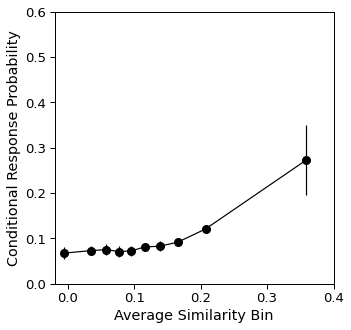

In [11]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5, 5))
    x = pb_sem_crp_sub.groupby('sem_bin').agg({'sem_bin_mean':'mean'})['sem_bin_mean'].to_numpy()
    y = pb_sem_crp_sub.groupby('sem_bin').agg({'prob':'mean'})['prob'].to_numpy()
    std = pb_sem_crp_sub.groupby('sem_bin').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = pb_sem_crp_sub.groupby('sem_bin').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))

    plt.errorbar(x, y, yerr=yerr, color='k', marker='o', markersize=8);
    plt.ylim(0,0.60)
    plt.xlim(-0.02, 0.40)
    plt.xticks(np.arange(0,0.5, 0.1))
    plt.xlabel('Average Similarity Bin')
    plt.ylabel('Conditional Response Probability')
    plt.savefig('figures/exp2_semcrp.pdf')

## Change in the effect across sessions

In [12]:
exp2_dist_fact = sem_ffr_evs.groupby(['subject', 'session']).apply(
    pb.pd_dist_fact, itemno_column='item_num_new', list_index=['subject', 'session'], 
    pres_type="WORD", rec_type="REC_WORD", dist_mat=sem_sims, is_similarity=True).reset_index().rename(columns={0:'prob'})

In [14]:
exp2_dist_fact.to_csv('dataframes/exp2_sem.csv', index=False)

In [15]:
loftus_masson_sem=loftus_masson(exp2_dist_fact, 'subject', 'session', 'prob')

In [16]:
loftus_masson_sem.to_csv('dataframes/exp2_semtrend.csv', index=False)

# Lag-CRP

## Overall effect

In [17]:
lag_crp_ffr_evs = pd.concat([pres_evs, ffr_evs])

In [18]:
ffr_dfs=[]
for i in range(26):
    ffr_evs_crp=ffr_evs.copy()
    ffr_evs_crp['list']=i
    ffr_dfs.append(ffr_evs_crp)

In [19]:
ffr_dfs.append(pres_evs)
lag_crp_df = pd.concat(ffr_dfs)

In [20]:
pb_min_crp = lag_crp_df.groupby(['subject','session']).apply(pb.pd_min_crp, lag_num=10,
                                itemno_column='item_num_new', max_n_reps=3).reset_index()

In [21]:
pb_min_crp_sub = pb_min_crp.groupby(['subject','lag']).agg({'prob':'mean'}).reset_index()

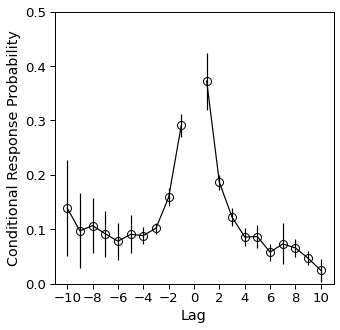

In [22]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5, 5))
    x = np.arange(-10,11,dtype=int)
    y = pb_min_crp_sub.groupby('lag').agg({'prob':'mean'})['prob'].to_numpy()
    std = pb_min_crp_sub.groupby('lag').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = pb_min_crp_sub.groupby('lag').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))

    plt.errorbar(x, y, yerr=yerr, color='k', marker='o', markersize=8, fillstyle='none');
    plt.ylim(0,0.5)
    plt.xlabel('Lag')
    plt.ylabel('Conditional Response Probability')
    plt.xticks(np.arange(-10,11,2))
    plt.savefig('figures/exp2_lag.pdf')

## Change in the effect across sessions 

In [23]:
exp2_temp_fact = lag_crp_df.groupby(['subject', 'session']).apply(
    pb.pd_min_temp_fact, pres_type="WORD", rec_type='REC_WORD',
    itemno_column='item_num_new', max_n_reps=3).to_frame('temp_fact').reset_index().rename(columns={'temp_fact':'prob'})

In [24]:
exp2_temp_fact.to_csv('dataframes/exp2_temp.csv', index=False)

In [25]:
loftus_masson_temp=loftus_masson(exp2_temp_fact, 'subject', 'session', 'prob')

## Combining sem and temp in same graph

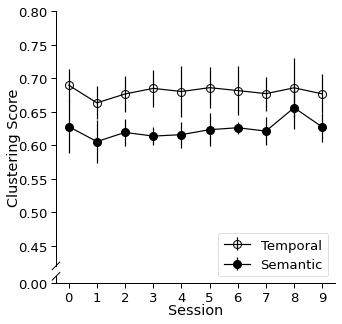

In [26]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5, 
#                           rc={'axes.labelsize': 100}
                         ):
    fig = plt.figure(figsize=(5, 5))
    bax = brokenaxes(ylims=((0, 0.01), (0.42
                                        , 0.80)), hspace=.08)
    x = np.arange(0,10,dtype=int)
    
    y_temp = loftus_masson_temp.groupby('session').agg(sem_prob=('adj_prob','mean'))['sem_prob'].to_numpy()
    std_temp = loftus_masson_temp.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count_temp = loftus_masson_temp.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()
    yerr_temp = 1.96 * (std_temp / (count_temp ** 0.5))
    bax.errorbar(x, y_temp, yerr = yerr_temp, color='k', marker='o', markersize=8,fillstyle='none',label='Temporal')
    
    y_sem = loftus_masson_sem.groupby('session').agg(sem_prob=('adj_prob','mean'))['sem_prob'].to_numpy()
    std_sem = loftus_masson_sem.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count_sem = loftus_masson_sem.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()
    yerr_sem = 1.96 * (std_sem / (count_sem ** 0.5))
    bax.errorbar(x, y_sem, yerr = yerr_sem, color='k', marker='o',markersize=8, label='Semantic')
    
  
    
    

    bax.legend(loc=4)
    
    bax.set_xticks(np.arange(1,10,1,dtype=int))
    bax.set_xlabel('Session')
    bax.set_ylabel('Clustering Score')
    plt.savefig('figures/exp2_sem_and_temp.pdf')

## Subjective CRP

## Overall effect 

In [27]:
# give item numbers to recalled items that will serve as presetation items
item_col = 'item_name'
item_num_col = 'ffr_item_num'
item_num_df = ffr_evs.drop_duplicates(subset=item_col, ignore_index=True)[item_col].reset_index().rename(columns={'index': item_num_col})
item_num_df[item_num_col] = item_num_df[item_num_col] + 1
ffr_evs = ffr_evs.merge(item_num_df, how='left')

In [28]:
# make the this df into a presentation events df
ffr_pres_evs = ffr_evs.copy()
ffr_pres_evs['type'] = "FFR_WORD"  # creates a distinction between pres and rec evs
ffr_pres_evs['session'] = ffr_pres_evs['session'] + 1   # add 1 to sess bc. analysis based on prev sess
ffr_pres_evs = ffr_pres_evs.query('session!=10')

In [29]:
num_recs = ffr_pres_evs.groupby(['subject','session']).agg(num_recs=('item_name','count')).reset_index()

In [30]:
ffr_pres_evs = ffr_pres_evs.merge(num_recs, on=['subject','session'], how='left')

In [31]:
# only keep sessions with more than 10 recalls serving as presentation events
ffr_pres_evs = ffr_pres_evs[ffr_pres_evs['num_recs']>10]

In [32]:
# session 0 has no prev sess, so no presenation evs
ffr_rec_evs = ffr_evs.query('session != 0') 

In [33]:
ffr_subj_org_evs = pd.concat([ffr_pres_evs, ffr_rec_evs])

In [34]:
pb_min_subj = ffr_subj_org_evs.groupby(['subject', 'session']).apply(pb_min.pd_min_crp_subj, lag_num=10,
                                                   pres_type='FFR_WORD',
                                          rec_type='REC_WORD', 
                                          itemno_column='ffr_item_num', 
                                           max_n_reps=4).reset_index()

In [35]:
pb_min_subj_sub = pb_min_subj.groupby(['subject', 'lag']).agg({'prob':'mean'}).reset_index()

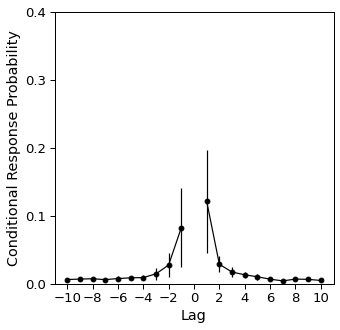

In [36]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5): 
    fig = plt.figure(figsize=(5, 5))
    x = np.arange(-10,11,dtype=int)
    y = pb_min_subj_sub.groupby('lag').agg({'prob':'mean'})['prob'].to_numpy()
    std = pb_min_subj_sub.groupby('lag').agg(std=('prob',std_ddof))['std'].to_numpy()
    count = pb_min_subj_sub.groupby('lag').agg(count=('prob','count'))['count'].to_numpy()
    yerr = 1.96 * (std / (count ** 0.5))

    plt.errorbar(x, y, yerr=yerr, color='k', marker='o');
    plt.ylim(0,0.40)
    plt.yticks(np.arange(0,0.5,0.1))
    plt.xlabel('Lag')
    plt.ylabel('Conditional Response Probability')
    plt.xticks(np.arange(-10,11,2))
    plt.savefig('figures/exp2_subj.pdf')

## Change in the effect across sessions

In [37]:
exp2_subj_fact = ffr_subj_org_evs.groupby(['subject', 'session']).apply(
    pb.pd_min_temp_fact, pres_type="FFR_WORD", rec_type='REC_WORD', list_index=['subject', 'session'],
    itemno_column='ffr_item_num', max_n_reps=4).to_frame('prob').reset_index()

In [38]:
exp2_subj_fact = exp2_subj_fact.dropna(axis='rows')

In [40]:
exp2_subj_fact.to_csv('dataframes/exp2_subj.csv', index=False)

In [41]:
loftus_masson_subj=loftus_masson(exp2_subj_fact, 'subject', 'session', 'prob')

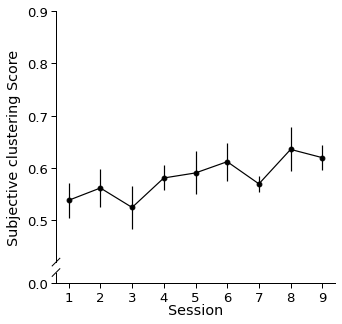

In [42]:
def std_ddof(a):
    std = np.std(a, ddof=1)
    return std

with sns.plotting_context(context='paper', font_scale=1.5, 
#                           rc={'axes.labelsize': 100}
                         ):
    fig = plt.figure(figsize=(5, 5))
    bax = brokenaxes(ylims=((0, 0.02), (0.42
                                        , 0.90)), hspace=.08)
    x = np.arange(1,10,dtype=int)
    y = loftus_masson_subj.groupby('session').agg(subj_prob=('adj_prob','mean'))['subj_prob'].to_numpy()
    std = loftus_masson_subj.groupby('session').agg(std=('adj_prob',std_ddof))['std'].to_numpy()
    count = loftus_masson_subj.groupby('session').agg(count=('adj_prob', 'count'))['count'].to_numpy()

    yerr = 1.96 * (std / (count ** 0.5))
    bax.errorbar(x, y, yerr = yerr, color='k', marker='o' )
    bax.set_xticks(np.arange(1,10,1,dtype=int))
    bax.set_xlabel('Session')
    bax.set_ylabel('Subjective clustering Score')
    plt.savefig('figures/exp2_subjtrend.pdf')